## LeNet-5

##### 모델 구조

- 합성곱 신경망 개념을 최초로 Yann LeCun이 개발한 CNN 구조

- 현재 CNN의 초석

<img src="https://blog.kakaocdn.net/dn/bvndfd/btr92v4mDpH/AUWzSw5MSO2TLm1eSURGQ1/img.png" width="800px">

---

##### (1) 라이브러리 호출

In [2]:
# 모델 학습의 진행 상태 확인을 위한 라이브러리
!pip install --user tqdm

In [3]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F

import os
import time
import random
import pandas as pd
import matplotlib.pyplot as plt

import cv2
from PIL import Image

from tqdm import tqdm_notebook as tqdm

##### (2) 이미지 데이터 내려받기

In [4]:
!git clone 'https://github.com/gilbutITbook/080289.git'

Cloning into '080289'...
remote: Enumerating objects: 2278, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 2278 (delta 4), reused 28 (delta 3), pack-reused 2246
Receiving objects: 100% (2278/2278), 330.30 MiB | 20.55 MiB/s, done.
Resolving deltas: 100% (13/13), done.
Updating files: 100% (2591/2591), done.


In [5]:
cat_directory = r'/content/080289/chap06/data/dogs-vs-cats/Cat'
dog_directory = r'/content/080289/chap06/data/dogs-vs-cats/Dog'

cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)])
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])

images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

In [6]:
random.seed(2023)
random.shuffle(correct_images_filepaths) # 이미지 파일을 랜덤으로 섞음

train_images_filepaths = correct_images_filepaths[:400] # 학습 이미지 400장
val_images_filepaths = correct_images_filepaths[400:-10] # 검증 이미지 92장
test_images_filepaths = correct_images_filepaths[-10:] # 테스트 이미지 10장

len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths)

(400, 92, 10)

In [7]:
# 시각화를 위한 함수
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))

    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = 'green' if true_label == predicted_label else 'red'
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()

    plt.tight_layout()
    plt.show()

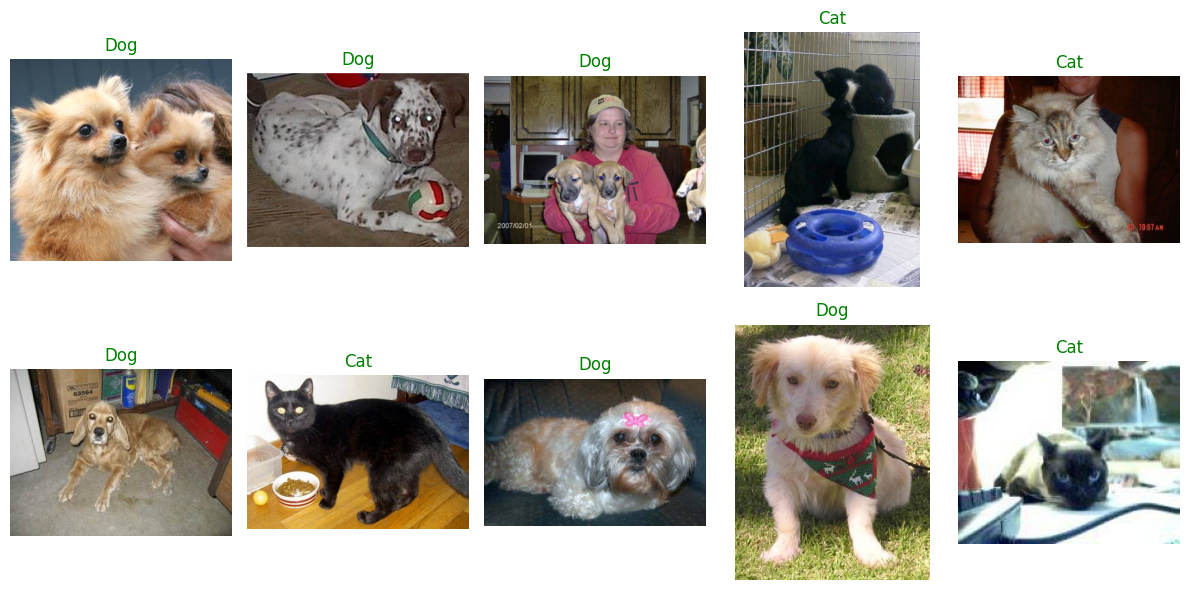

In [8]:
display_image_grid(test_images_filepaths)

##### (3) 이미지 데이터 전처리

In [9]:
# 전처리 기법 클래스
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train' : transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),

            'val' : transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),

        }

    def __call__(self, img, phase): # 인스턴스 자체를 호출하면 해당 함수의 return 값이 반환됨
        return self.data_transform[phase](img)

In [10]:
# 데이터셋 클래스
class DogvsCatDataset(Dataset):
    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list # 이미지 파일 목록
        self.transform = transform # 전처리 기법
        self.phase = phase # 학습/테스트

    def __len__(self):
        return len(self.file_list) # 데이터셋의 전체 길이 반환

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase) # 전처리 적용
        label = img_path.split('/')[-1].split('.')[0] # 파일명에서 레이블 추출

        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0

        return img_transformed, label

In [11]:
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [12]:
train_dataset = DogvsCatDataset(train_images_filepaths, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')

*Dataset*

- X : 이미지 데이터

  - (3x224x224)

In [13]:
train_dataset.__getitem__(77)[0]
train_dataset.__getitem__(77)[0].size()

torch.Size([3, 224, 224])

- y : 레이블

  - Dog/Cat

In [14]:
train_dataset.__getitem__(77)[1]

1

*DataLoader*

In [15]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

dataloader_dict = {'train' : train_dataloader, 'val' : val_dataloader}

In [16]:
inputs, label = next(iter(train_dataloader))

- batch_size = 32

  - 한 번에 이미지 32장씩 처리

In [17]:
inputs.size()

torch.Size([32, 3, 224, 224])

In [18]:
label

tensor([0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1,
        1, 0, 0, 0, 1, 1, 1, 1])

##### (4) 모델 생성

In [19]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.fc1 = nn.Linear(32*53*53, 512)
        self.fc2 = nn.Linear(512, 2)
        self.output = nn.Softmax(dim=1)


    def forward(self, x):
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.output(out)
        return out

- feature map 사이즈 계산 : `(W - F + 2P) / S + 1`

- 입력 데이터 : (3x224x224) RGB 이미지

- Conv 1 : (224 - 5 + 0) / 1 + 1 = 220 -> **(16x220x220)**

- Max Pool 1 : (2x2) -> **(16x110x110)**

- Conv 2 : (110 - 5 + 0) / 1 + 1 = 106 -> **(32x106x106)**

- Max Pool 2 : (2x) -> **(32x53x53)**

- Flattening : **(1x89888)**

- FC 1 : 89888 -> **512**

- FC 2 : 512 -> **2**

In [20]:
model = LeNet()
model

LeNet(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=89888, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (output): Softmax(dim=1)
)

In [21]:
# 모델 출력을 위한 라이브러리
!pip install torchsummary

In [26]:
from torchsummary import summary

summary(model.to(torch.device('cuda')), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 220, 220]           1,216
              ReLU-2         [-1, 16, 220, 220]               0
         MaxPool2d-3         [-1, 16, 110, 110]               0
            Conv2d-4         [-1, 32, 106, 106]          12,832
              ReLU-5         [-1, 32, 106, 106]               0
         MaxPool2d-6           [-1, 32, 53, 53]               0
            Linear-7                  [-1, 512]      46,023,168
            Linear-8                    [-1, 2]           1,026
           Softmax-9                    [-1, 2]               0
Total params: 46,038,242
Trainable params: 46,038,242
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 19.47
Params size (MB): 175.62
Estimated Total Size (MB): 195.67
--------------------------------

-> 총 46,023,168개의 파라미터를 학습해야 하는 것을 알 수 있음

##### (5) 파라미터 설정

In [27]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [29]:
model = model.to(device)
criterion = criterion.to(device)
num_epoch = 10

##### (6) 모델 학습

In [32]:
def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):
    since = time.time()
    best_acc = 0.0

    for epoch in range(num_epoch):
        print(f"Epoch {epoch+1}/{num_epoch}")
        print('-'*20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # 학습 모드
            else:
                model.eval() # 검증 모드

            epoch_loss = 0.0
            epoch_corrects = 0

            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad() # 기울기(gradient) 초기화

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs) # 모델 적용
                    _, preds = torch.max(outputs, 1) # 예측값 계산
                    loss = criterion(outputs, labels) # 손실함수 값 계산

                    if phase == 'train':
                        loss.backward()
                        optimizer.step() # 가중치(weight) 업데이트

                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)

            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} ACC: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict() # 최적의 모델 저장

    time_elapsed = time.time()
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    return model

In [33]:
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/10
--------------------


<ipython-input-32-07a4f091e5cf>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm(dataloader_dict[phase]):


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6440 ACC: 0.6500


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6858 ACC: 0.5652
Epoch 2/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6408 ACC: 0.6450


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6804 ACC: 0.5217
Epoch 3/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6451 ACC: 0.6250


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6837 ACC: 0.5870
Epoch 4/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6311 ACC: 0.6725


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6772 ACC: 0.5652
Epoch 5/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6261 ACC: 0.6600


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6799 ACC: 0.5761
Epoch 6/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6222 ACC: 0.6700


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6811 ACC: 0.5543
Epoch 7/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6234 ACC: 0.6750


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7334 ACC: 0.5109
Epoch 8/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6255 ACC: 0.6475


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6757 ACC: 0.6087
Epoch 9/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6217 ACC: 0.6850


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6769 ACC: 0.5652
Epoch 10/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6189 ACC: 0.6575


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6785 ACC: 0.5761
Training complete in 28226239m 51s
Best val Acc: 0.608696


##### (7) 모델 테스트

In [34]:
id_list = []
pred_list = []
_id = 0
with torch.no_grad():
    for test_path in tqdm(test_images_filepaths):
        img = Image.open(test_path)
        _id = test_path.split('/')[-1].split('.')[1]
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase='val')
        img = img.unsqueeze(0)
        img = img.to(device)

        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs, dim=1)[:, 1].tolist()
        id_list.append(_id)
        pred_list.append(preds[0])

result = pd.DataFrame({
    'id' : id_list,
    'label' : pred_list,
})

result.sort_values(by='id', inplace=True)
result.reset_index(drop=True, inplace=True)

result.to_csv('/content/080289/chap06/data/LeNet', index=False)

<ipython-input-34-3748753cce3f>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for test_path in tqdm(test_images_filepaths):


  0%|          | 0/10 [00:00<?, ?it/s]

In [37]:
result.head(10)

,id,label
0,135,0.594601
1,153,0.522031
2,196,0.620483
3,245,0.326938
4,36,0.522920
5,5,0.509306
6,52,0.387192
7,77,0.672752
8,79,0.402299
9,95,0.509341


In [40]:
class_ = classes = {0 : 'cat', 1 : 'dog'}

In [41]:
# 시각화를 위한 함수
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))

    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        a = random.choice(result['id'].values)
        label = result.loc[result['id'] == a, 'label'].values[0]

        if label > 0.5:
            label = 1
        else:
            label = 0

        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()

    plt.tight_layout()
    plt.show()

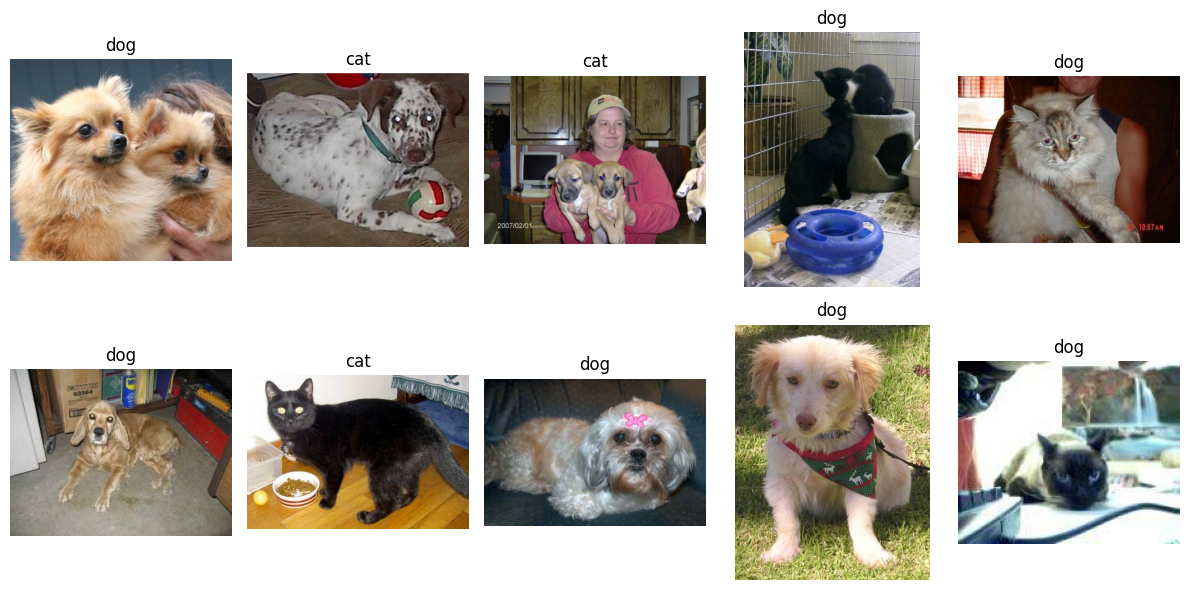

In [42]:
display_image_grid(test_images_filepaths)